# MNIST Large Untrained Net CNN Exc Inh

Derived from https://www.kaggle.com/code/amyjang/tensorflow-mnist-cnn-tutorial/notebook

In [154]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import backend as K

print(tf.__version__)

2.8.2


In [155]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

In [156]:
inlineImplementation = False	#orig: True #True: excitatory/inhibitory neurons are on same sublayer, False: add inhibitory neurons to separate preceding sublayer
if(inlineImplementation):
    positiveWeightImplementation = False	#orig: True #optional
    if(not positiveWeightImplementation):
        integrateWeights = True    #orig: False #optional
        if(integrateWeights):
            integrateWeights1 = False    #explicitly declare E/I neurons
            integrateWeights2 = True    #implicitly declare E/I neurons   
            integrateWeightsInitialiseZero = False   #miscellaneous training performance improvement (single EI layer only)
else:
    positiveWeightImplementation = False    #False: only current coded implementation

inputLayerExcitatoryOnly = True #True: only current coded implementation

preFinalDenseLayer = False

generateUntrainedNetwork = False
if(generateUntrainedNetwork):
    #only train the last layer
    numberOfHiddenLayers = 2    #default: 2    #if 0 then useSVM=True
else:
    numberOfHiddenLayers = 2   #default: 4

if(numberOfHiddenLayers > 1):
    addSkipLayers = False   #optional
else:
    addSkipLayers = False   #mandatory

layerSizeBase = 32  #default: 32

batch_size = 64 #default: 64
epochs = 5  #1  #5

debugNoEIneurons = False
debugPreTrainWeights = True
debugPreTrainOutputs = True
debugPostTrainWeights = True
debugPostTrainOutputs = True

## Load data

In [157]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [158]:
input_shape = (28, 28, 1)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

In [159]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


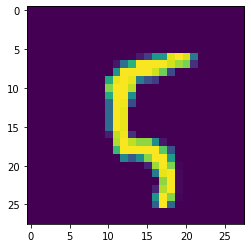

In [160]:
plt.imshow(x_train[100][:,:,0])
print(y_train[100])

## Define model

In [161]:
num_classes = 10

In [162]:
def EIactivation(x):
    return K.maximum(x, 0)  #ReLU

def EIactivationExcitatory(x):
    if(inlineImplementation):
        if(positiveWeightImplementation):
            return K.maximum(x, 0)  #ReLU
        else:
             print("EIactivationExcitatory error: requires positiveWeightImplementation")      
    else:
        print("EIactivationExcitatory error: requires inlineImplementation")

def EIactivationInhibitory(x):
    if(inlineImplementation):
        if(positiveWeightImplementation):
            return -(K.maximum(x, 0))   #ReLU with negative output
        else:
             print("EIactivationInhibitory error: requires positiveWeightImplementation")      
    else:
        print("inlineImplementation error: requires inlineImplementation")

def EIweightInitializer(shape, dtype=None):
    if(inlineImplementation):
        if(positiveWeightImplementation):
            w = tf.math.abs(tf.random.normal(shape, dtype=dtype))
        else:
            if(integrateWeights):
                if(integrateWeightsInitialiseZero):
                    w = tf.zeros(shape, dtype=dtype)    #tf.math.abs(tf.random.normal(shape, dtype=dtype))
                else:
                    #print("shape = ", shape)
                    w = tf.math.abs(tf.random.normal(shape, dtype=dtype))
                    wEIsize = w.shape[2]//2
                    wSignE = tf.ones([w.shape[0], w.shape[1], wEIsize, w.shape[3]])
                    wSignI = tf.ones([w.shape[0], w.shape[1], wEIsize, w.shape[3]])
                    wSignI = tf.multiply(wSignI, -1)
                    wSign = tf.concat([wSignE, wSignI], axis=2)
                    w = tf.multiply(w, wSign)
            else:
                print("EIweightInitializer error: requires !positiveWeightImplementation:integrateWeights")
    else:
        print("EIweightInitializer error: requires inlineImplementation") 

    return w

def EIweightInitializerExcitatory(shape, dtype=None):
    if(positiveWeightImplementation):
        print("EIweightInitializerExcitatory error: requires !positiveWeightImplementation")
    else:
        return tf.math.abs(tf.random.normal(shape, dtype=dtype))

def EIweightInitializerInhibitory(shape, dtype=None):
    if(positiveWeightImplementation):
        print("EIweightInitializerExcitatory error: requires !positiveWeightImplementation")
    else:
        return tf.math.negative(tf.math.abs(tf.random.normal(shape, dtype=dtype)))

class negative(tf.keras.constraints.Constraint):
    #based on https://www.tensorflow.org/api_docs/python/tf/keras/constraints/Constraint
    def __init__(self):
        pass
    def __call__(self, w):
        return w * tf.cast(tf.math.less_equal(w, 0.), w.dtype)

class positiveOrNegative(tf.keras.constraints.Constraint):
    #based on https://www.tensorflow.org/api_docs/python/tf/keras/constraints/Constraint
    def __init__(self):
        pass
    def __call__(self, w):
        w_shape = w.shape
        #print("w_shape = ", w_shape)
        wEIsize = w.shape[2]//2
        wE = w[:, :, 0:wEIsize]
        wI = w[:, :, wEIsize:]
        wEcheck = tf.greater_equal(wE, 0)
        wIcheck = tf.less_equal(wI, 0)
        wEcheck = tf.cast(wEcheck, tf.float32)
        wIcheck = tf.cast(wIcheck, tf.float32)
        wE = tf.multiply(wE, wEcheck)
        wI = tf.multiply(wI, wIcheck)
        w = tf.concat([wE, wI], axis=2)
        return w

In [163]:

if(inlineImplementation):
    if(positiveWeightImplementation):
        EIweightConstraint = tf.keras.constraints.non_neg()
        constrainBiases = True   #ensure positive biases also
        if(constrainBiases):
            EIbiasConstraint = tf.keras.constraints.non_neg()
            constrainBiasesLastLayer = False
            if(constrainBiasesLastLayer):
                EIbiasConstraintLastLayer = tf.keras.constraints.non_neg()
            else:
                EIbiasConstraintLastLayer = None
        else:
            EIbiasConstraint = None
            EIbiasConstraintLastLayer = None
    else:
        if(integrateWeights):
            EIweightConstraint = positiveOrNegative()
            EIbiasConstraint = None
        else:
            EIweightConstraintPositive = tf.keras.constraints.non_neg()
            EIweightConstraintNegative = negative()
            constrainBiases = False
            if(constrainBiases):
                EIbiasConstraintPositive = tf.keras.constraints.non_neg()
                EIbiasConstraintNegative = negative()
            else:
                EIbiasConstraintPositive = None
                EIbiasConstraintNegative = None
else:
    EIweightConstraintPositive = tf.keras.constraints.non_neg()
    EIweightConstraintNegative = negative()
    constrainBiases = False
    if(constrainBiases):
        EIbiasConstraintPositive = tf.keras.constraints.non_neg()
        EIbiasConstraintNegative = negative()
    else:
        EIbiasConstraintPositive = None
        EIbiasConstraintNegative = None
    EIweightConstraintLastLayer = None
    EIbiasConstraintLastLayer = None 

if(generateUntrainedNetwork):
    #only train the last layer
    generateLargeNetwork = True
else:
    generateLargeNetwork = False

if(generateLargeNetwork):
    largeNetworkRatio = 10    #100
    generateLargeNetworkExpansion = False
    if(generateLargeNetworkExpansion):
        generateLargeNetworkRatioExponential = False
else:
    generateLargeNetworkRatio = False

def getLayerRatio(layerIndex):
    layerRatio = 1
    if(generateLargeNetwork):
        if(generateLargeNetworkExpansion):
            if(generateLargeNetworkRatioExponential):
                layerRatio = largeNetworkRatio**layerIndex
            else:
                layerRatio = largeNetworkRatio * layerIndex
        else:
            layerRatio = largeNetworkRatio
    else:
        layerRatio = 1
    return int(layerRatio)

def createEIlayer(layerIndex, h0, firstLayer=False, maxpool2d=None, dropout=None):
    layerRatio = getLayerRatio(2)
    if(debugNoEIneurons):
        h1E = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same')(h0)
        h1I = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same')(h0)
        h1E = tf.keras.layers.Activation(EIactivationExcitatory)(h1E)
        h1I = tf.keras.layers.Activation(EIactivationInhibitory)(h1I)
        h1 = tf.keras.layers.Concatenate(axis=2)([h1E, h1I])
    else:
        if(inlineImplementation):
            if(positiveWeightImplementation):
                h1E = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same', kernel_initializer=EIweightInitializer, kernel_constraint=EIweightConstraint, bias_constraint=EIbiasConstraint)(h0)
                h1I = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same', kernel_initializer=EIweightInitializer, kernel_constraint=EIweightConstraint, bias_constraint=EIbiasConstraint)(h0)
                h1E = tf.keras.layers.Activation(EIactivationExcitatory)(h1E)
                h1I = tf.keras.layers.Activation(EIactivationInhibitory)(h1I)
                h1 = tf.keras.layers.Concatenate()([h1E, h1I])
                if(maxpool2d is not None):
                    h1 = tf.keras.layers.MaxPool2D(strides=maxpool2d)(h1)
                if(dropout is not None):
                    h1 = tf.keras.layers.Dropout(dropout)(h1)
            else:
                if(integrateWeights):
                    if(integrateWeights1):
                        if(firstLayer):
                            h1E = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same')(h0)
                            h1I = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same')(h0)
                        else:
                            h1E = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same', kernel_initializer=EIweightInitializer, kernel_constraint=EIweightConstraint, bias_constraint=EIbiasConstraint)(h0)
                            h1I = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same', kernel_initializer=EIweightInitializer, kernel_constraint=EIweightConstraint, bias_constraint=EIbiasConstraint)(h0)
                        h1E = tf.keras.layers.Activation(EIactivation)(h1E)
                        h1I = tf.keras.layers.Activation(EIactivation)(h1I)
                        h1 = tf.keras.layers.Concatenate(axis=2)([h1E, h1I])
                    elif(integrateWeights2):
                        if(firstLayer):
                            h1 = tf.keras.layers.Conv2D(layerSizeBase*layerRatio*2, (5,5), padding='same')(h0)
                        else:
                            h1 = tf.keras.layers.Conv2D(layerSizeBase*layerRatio*2, (5,5), padding='same', kernel_initializer=EIweightInitializer, kernel_constraint=EIweightConstraint, bias_constraint=EIbiasConstraint)(h0)
                        h1 = tf.keras.layers.Activation(EIactivation)(h1)
                    if(maxpool2d is not None):
                        h1 = tf.keras.layers.MaxPool2D(strides=maxpool2d)(h1)
                    if(dropout is not None):
                        h1 = tf.keras.layers.Dropout(dropout)(h1)
                else:
                    if(firstLayer):
                        h1E = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same')(h0)
                        h1I = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same')(h0)
                    else:
                        h0E, h0I = h0
                        h1Ee = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same', kernel_initializer=EIweightInitializerExcitatory, kernel_constraint=EIweightConstraintPositive, bias_constraint=EIbiasConstraintPositive)(h0E) #excitatory neuron excitatory inputs
                        h1Ei = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same', kernel_initializer=EIweightInitializerInhibitory, kernel_constraint=EIweightConstraintNegative, bias_constraint=EIbiasConstraintNegative)(h0I) #excitatory neuron inhibitory inputs
                        h1Ie = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same', kernel_initializer=EIweightInitializerExcitatory, kernel_constraint=EIweightConstraintPositive, bias_constraint=EIbiasConstraintPositive)(h0E) #inhibitory neuron excitatory inputs
                        h1Ii = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same', kernel_initializer=EIweightInitializerInhibitory, kernel_constraint=EIweightConstraintNegative, bias_constraint=EIbiasConstraintNegative)(h0I) #inhibitory neuron inhibitory inputs
                        h1E = tf.keras.layers.Add()([h1Ee, h1Ei])
                        h1I = tf.keras.layers.Add()([h1Ie, h1Ii])
                    h1E = tf.keras.layers.Activation(EIactivation)(h1E)
                    h1I = tf.keras.layers.Activation(EIactivation)(h1I)
                    if(maxpool2d is not None):
                        h1E = tf.keras.layers.MaxPool2D(strides=maxpool2d)(h1E)
                        h1I = tf.keras.layers.MaxPool2D(strides=maxpool2d)(h1I)
                    if(dropout is not None):
                        h1E = tf.keras.layers.Dropout(dropout)(h1E)
                        h1I = tf.keras.layers.Dropout(dropout)(h1I)
                    h1 = (h1E, h1I)
        else:
            if(firstLayer):
                previousNumChannels = 1
            else:
                previousNumChannels = layerSizeBase*layerRatio
            h1I = tf.keras.layers.Conv2D(previousNumChannels, (5,5), padding='same', kernel_initializer=EIweightInitializerExcitatory, kernel_constraint=EIweightConstraintPositive, bias_constraint=EIbiasConstraintPositive)(h0) #inhibitory interneuron (excitatory inputs)
            h1I = tf.keras.layers.Activation(EIactivation)(h1I) #not required
            h1I = h1I*calculateInhibitoryNeuronNormalisationFactor(h0, h1I)
            h1Ee = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same', kernel_initializer=EIweightInitializerExcitatory, kernel_constraint=EIweightConstraintPositive, bias_constraint=EIbiasConstraintPositive)(h0) #excitatory neuron excitatory inputs
            h1Ei = tf.keras.layers.Conv2D(layerSizeBase*layerRatio, (5,5), padding='same', kernel_initializer=EIweightInitializerInhibitory, kernel_constraint=EIweightConstraintNegative, bias_constraint=EIbiasConstraintNegative)(h1I) #excitatory neuron inhibitory inputs       
            h1E = tf.keras.layers.Add()([h1Ee, h1Ei])
            h1E = tf.keras.layers.Activation(EIactivation)(h1E)
            h1 = h1E
    return h1

def calculateInhibitoryNeuronNormalisationFactor(h0, h1I):
    h1InormalisationFactor = tf.reduce_mean(h0)/tf.reduce_mean(h1I)
    return h1InormalisationFactor

def concatEIneurons(h):
    if(inlineImplementation):
        if(positiveWeightImplementation):
            return h
        else: 
            if(integrateWeights):
                pass
            else:
                hE, hI = h
                h = tf.keras.layers.Concatenate()([hE, hI])
            return h
    else:
        return h


x = tf.keras.layers.Input(shape=input_shape)
h0 = x
hLast = h0
if(numberOfHiddenLayers >= 1):
    h1 = createEIlayer(1, h0, firstLayer=True)
    hLast = h1
if(numberOfHiddenLayers >= 2):
    h2 = createEIlayer(2, h1, maxpool2d=(1,1), dropout=0.25)
    hLast = h2
if(numberOfHiddenLayers >= 3):
    h3 = createEIlayer(3, h2)
    hLast = h3
if(numberOfHiddenLayers >= 4):
    h4 = createEIlayer(4, h3, maxpool2d=(2,2))
    hLast = h4
if(addSkipLayers):
    mList = []
    if(numberOfHiddenLayers >= 1):
        m1 = tf.keras.layers.Flatten()(concatEIneurons(h1))
        mList.append(m1)
    if(numberOfHiddenLayers >= 2):
        m2 = tf.keras.layers.Flatten()(concatEIneurons(h2))
        mList.append(m2)
    if(numberOfHiddenLayers >= 3):
        m3 = tf.keras.layers.Flatten()(concatEIneurons(h3))
        mList.append(m3)
    if(numberOfHiddenLayers >= 4):
        m4 = tf.keras.layers.Flatten()(concatEIneurons(h4))
        mList.append(m4)
    hLast = tf.keras.layers.concatenate(mList)
else:
    hLast = concatEIneurons(hLast)

hLast = tf.keras.layers.Flatten()(hLast)
if(preFinalDenseLayer):
    hLast = tf.keras.layers.Dense(128, activation='relu')(hLast)
    hLast = tf.keras.layers.Dropout(0.5)(hLast)
if(generateUntrainedNetwork):
    hLast = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stop_gradient(x))(hLast)
y = tf.keras.layers.Dense(num_classes, activation='softmax')(hLast)
model = tf.keras.Model(x, y)



In [165]:
print(model.summary())
#printModelSummary(model)

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])

Model: "model_195"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_50 (Conv2D)             (None, 28, 28, 1)    26          ['input_11[0][0]']               
                                                                                                  
 activation_32 (Activation)     (None, 28, 28, 1)    0           ['conv2d_50[0][0]']              
                                                                                                  
 tf.math.reduce_mean_24 (TFOpLa  ()                  0           ['input_11[0][0]']               
 mbda)                                                                                    

In [166]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.995):
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [167]:
if(debugPreTrainWeights):
    testwritefile = open('weightsPreTrain.txt', 'w')
    for layerIndex, layer in enumerate(model.layers):
        heading = "\n" + "layer = " + str(layerIndex) + "\n"
        #print(heading)
        testwritefile.write(heading)
        weights = layer.get_weights()
        #print(weights)
        weightsS =  str(weights)
        testwritefile.write(weightsS)
    testwritefile.close()

In [168]:
if(debugPreTrainOutputs):
    testwritefile = open('outputPreTrain.txt', 'w')
    xTrainFirstSample = np.expand_dims(x_train[0], axis=0)
    for layerIndex, layer in enumerate(model.layers):
        heading = "\n" + "layer = " + str(layerIndex) + "\n"
        #print(heading)
        testwritefile.write(heading)
        func = K.function([model.get_layer(index=0).input], layer.output)
        layerOutput = func([xTrainFirstSample])  # input_data is a numpy array
        #print(layerOutput)
        layerOutputS =  str(layerOutput)
        testwritefile.write(layerOutputS)
    testwritefile.close()

## Train model

In [169]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
844/844 [==============================] - 397s 468ms/step - loss: 12.6260 - acc: 0.9015 - val_loss: 0.1418 - val_acc: 0.9638
Epoch 2/5
844/844 [==============================] - 398s 471ms/step - loss: 0.1304 - acc: 0.9679 - val_loss: 0.1345 - val_acc: 0.9660
Epoch 3/5
844/844 [==============================] - 395s 469ms/step - loss: 0.0963 - acc: 0.9774 - val_loss: 0.1392 - val_acc: 0.9730
Epoch 4/5
844/844 [==============================] - 392s 465ms/step - loss: 0.0801 - acc: 0.9814 - val_loss: 0.1329 - val_acc: 0.9763
Epoch 5/5
844/844 [==============================] - 399s 473ms/step - loss: 0.0670 - acc: 0.9859 - val_loss: 0.1541 - val_acc: 0.9793


In [170]:
if(debugPostTrainWeights):
    testwritefile = open('weightsPostTrain.txt', 'w')
    for layerIndex, layer in enumerate(model.layers):
        heading = "\n" + "layer = " + str(layerIndex) + "\n"
        #print(heading)
        testwritefile.write(heading)
        weights = layer.get_weights()
        #print(weights)
        weightsS =  str(weights)
        testwritefile.write(weightsS)
    testwritefile.close()

In [171]:
if(debugPostTrainOutputs):
    testwritefile = open('outputPostTrain.txt', 'w')
    xTrainFirstSample = np.expand_dims(x_train[0], axis=0)
    for layerIndex, layer in enumerate(model.layers):
        heading = "\n" + "layer = " + str(layerIndex) + "\n"
        #print(heading)
        testwritefile.write(heading)
        func = K.function([model.get_layer(index=0).input], layer.output)
        layerOutput = func([xTrainFirstSample])  # input_data is a numpy array
        #print(layerOutput)
        layerOutputS =  str(layerOutput)
        testwritefile.write(layerOutputS)
    testwritefile.close()

## Evaluate model

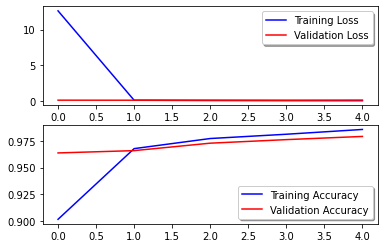

In [172]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [173]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 19s 59ms/step - loss: 0.1851 - acc: 0.9716
